In [1]:
!python3 --version
!pip freeze | grep qiskit
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal, UGate, PauliEvolutionGate
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.primitives import Estimator
import numpy as np

Python 3.12.3
qiskit==1.1.0
qiskit-algorithms==0.3.0
qiskit-nature==0.7.2


The Fauseweh-Zhu paper [here](https://arxiv.org/pdf/2112.04276).

Variational Quantum Design Course from IBMQ Learning
- [Ansatz](https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms) include the NLocal, we use TwoLocal
- [Optimisation](https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms) frameworks has also been discussed

In [2]:
chain_length = 4

num_layers = 1

shots = 2000

periods = 1

In [3]:
parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers

param_space = [Parameter(f'θ[{i}]') for i in range(parameter_space_size)]

In [4]:
Ω = 2.5
dt = 1/ (100*Ω)
A = 0
num_time_steps = periods / dt

In [21]:
def ansatz_circuit_0(qc, param_space):
    print('Number of params:',parameter_space_size)
    # layer 0
    param_counter=0
    for i in range(chain_length):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    
def ansatz_circuit_1(qc, param_space):
    param_counter = 2 * chain_length
    for i in range(chain_length-1):
        qc.cx(i,i+1)
    qc.cx(-1,0)
    for i in range(chain_length):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1

def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    ansatz_circuit_0(qc, param_space)
    for i in range(num_layers):
        ansatz_circuit_1(qc, param_space)

def ansatz_circuit_ladder(qc, param_space):
    register_size = chain_length*2
    # layer 0
    param_counter = 0
    for i in range(register_size):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(register_size):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(1,register_size//2):
        place = 2 * i - 1
        qc.cx(place,place+1)

def simulate(qc, shots=shots):
    initial_state = Statevector.from_instruction(qc)
    display(initial_state.draw())
    ham = hamiltonian(0)
    evolved_state = evolve(ham,qc)

def evolve(ham, initial_state, num_time_steps=num_time_steps):
    time=1
    evolution = TrotterQRTE(num_timesteps=num_time_steps)
    evolution_problem = TimeEvolutionProblem(ham, initial_state, time)
    evolution_result = evolution.evolve(evolution_problem)
    return evolution_result.evolved_state

def hamiltonian(t, A=2, J=1, Ω=Ω):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append([''.join(op), -J/4])
    for i in range(chain_length):
        op1, op2 = creator[:], creator[:]
        op1[i] = 'X'
        op2[i] = 'Y'
        ham.append([''.join(op1), A * np.cos(Ω*t)])
        ham.append([''.join(op2), A * np.sin(Ω*t)])
    ham = np.array(ham)
    return SparsePauliOp(ham[:,0], ham[:,1])

def unitary_time_evolution(ham, num_qbits=chain_length, time=num_time_steps*dt, dt=dt):#num_steps=num_time_steps):

    circuit = QuantumCircuit(num_qbits)
    
    for i in range(1, num_time_steps+1):
        circuit.append(PauliEvolutionGate(ham(i*dt), time=dt), range(num_qbits))

    # print('Unitary Evolution Circuit')
    # display(circuit.draw('mpl'))
    
    return circuit

def overlap(circuit, unitary_time_evolution):
    circuit_dagger = circuit.inverse()

    time_evolved = circuit.compose(unitary_time_evolution)

    circuit_dagger.compose(circuit)
    

### Functions for testing

def hamiltonian_linear(t, Δ=1, Ω=Ω):
    ham = SparsePauliOp(['Z','X'] , [-Δ/2, A/2/Ω*np.cos(Ω*t)])
    print(A*np.cos(Ω*t))
    return ham

In [22]:
print(hamiltonian_linear(0,2))

1.0
SparsePauliOp(['Z', 'X'],
              coeffs=[-1. +0.j,  0.2+0.j])


Number of params: 20


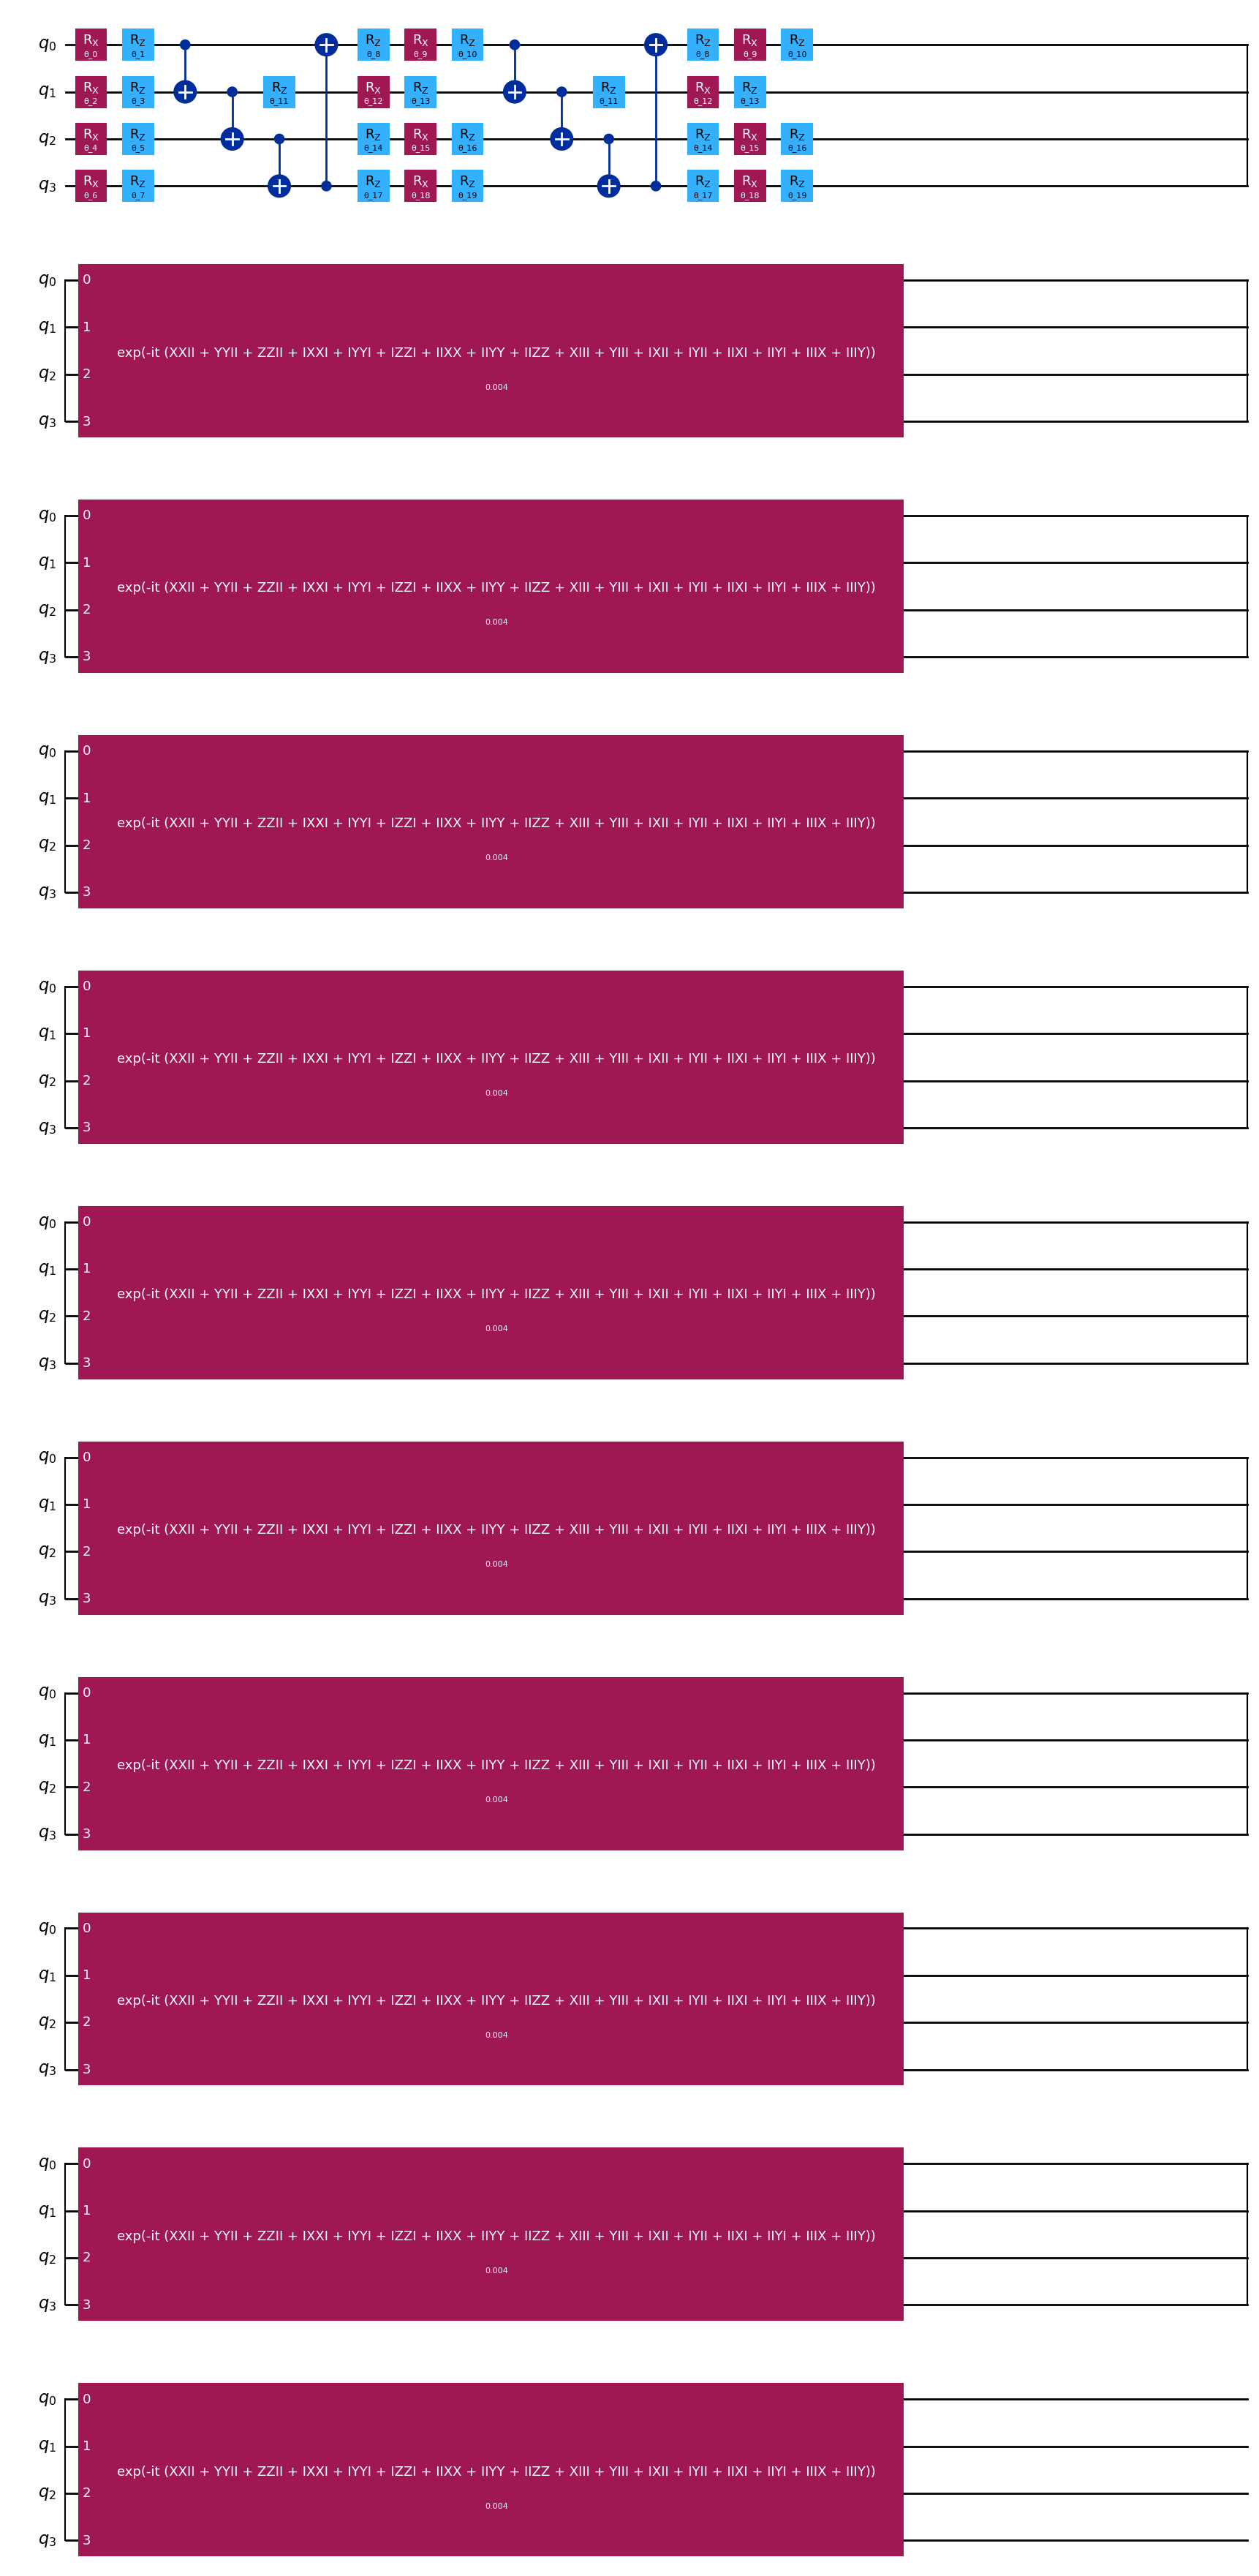

In [23]:
qc = QuantumCircuit(chain_length)

# qc.h(qc.qubits)

create_ansatz_circuit(qc, 2)

unitary = unitary_time_evolution(hamiltonian)

qc.compose(unitary, inplace=True)

# qc.measure_all()

qc.draw('mpl')

# print(time_evolver(qc, hamiltonian(0)))

0.9999500004166653
0.9998000066665778
0.9995500337489875
0.9992001066609779
0.9987502603949663
0.9982005399352042
0.9975510002532796
0.9968017063026194
0.9959527330119943
0.9950041652780258


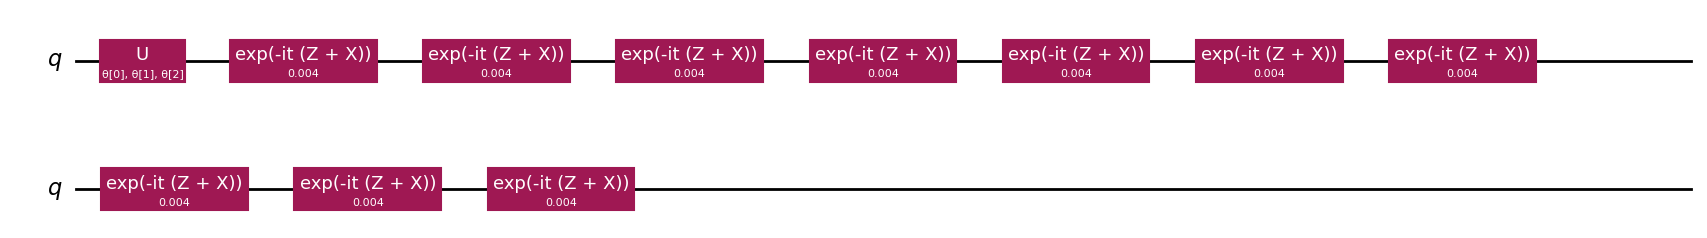

In [24]:
def linear():
    test_qc = QuantumCircuit(1)
    params = [Parameter(f'θ[{i}]') for i in range(3)]
    
    test_qc.u(*params, 0)

    unitary_timevo_circuit = unitary_time_evolution(hamiltonian_linear, 1)

    test_qc.compose(unitary_timevo_circuit, inplace=True)

    display(test_qc.draw('mpl'))

A = 1

linear()    

In [12]:
dt

0.004